In [254]:
!pip install transformers diffusers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [255]:
from pathlib import Path
from huggingface_hub import notebook_login

if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

In [256]:
import torch
from transformers  import CLIPTextModel, CLIPTokenizer

tokenizer = CLIPTokenizer.from_pretrained(
    "openai/clip-vit-large-patch14",
    torch_dtype = torch.float16,
)

text_encoder = CLIPTextModel.from_pretrained(
    "openai/clip-vit-large-patch14",
    torch_dtype = torch.float16,
).to("cuda")

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.
Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.16.self_attn.k_proj.bias', 'vision_model.encoder.layers.3.layer_norm1.weight', 'vision_model.encoder.layers.20.layer_norm1.weight', 'vision_model.encoder.layers.7.layer_norm1.bias', 'vision_model.encoder.layers.21.mlp.fc2.bias', 'vision_model.encoder.layers.5.self_attn.v_proj.bias', 'vision_model.encoder.layers.10.mlp.fc2.bias', 'vision_model.encoder.layers.9.self_attn.v_proj.weight', 'vision_model.encoder.layers.19.layer_norm2.bias', 'vision_model.encoder.layers.17.layer_norm2.weight', 'vision_model.encoder.layers.14.layer_norm1.bias', 'vision_model.encoder.layers.15.layer_norm2.bias', 'vision_model.encoder.layers.17.self_attn.v_proj.weight', 'vision_model.encoder.layers.4.self_attn.out_proj.weight', 'vision_model.encoder.layers.8.self_attn.k_proj.weight', 'vision_mod

In [257]:
from diffusers import AutoencoderKL, UNet2DConditionModel

vae = AutoencoderKL.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder = "vae",
    torch_dtype = torch.float16,
).to("cuda")

unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder = "unet",
    torch_dtype = torch.float16,
).to("cuda")

In [258]:
from diffusers import LMSDiscreteScheduler

beta_start,beta_end = 0.00085,0.012
scheduler = LMSDiscreteScheduler(
    beta_start=beta_start,
    beta_end=beta_end,
    beta_schedule="scaled_linear",
    num_train_timesteps=1000,
)

In [259]:
prompt = [
    "a drawing of an astronaut playing football",
    "an watercolor painting of an astronaut at a beach",
    "an image of an astronaut taking a selfie on mars",
    ]

height = 512
width = 512
num_inference_steps = 70
guidance_scale = 7.5
batch_size = len(prompt)

In [260]:
text_input = tokenizer(
    prompt,
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
)
text_input

{'input_ids': tensor([[49406,   320,  3610,   539,   550, 18376,  1629,  1882, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407],
        [49406,   550, 14211,  3086,   539,   550, 18376,   536,   320,  2117,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 

In [261]:
text_embedding = text_encoder(
    text_input.input_ids.to("cuda")
)[0].half()
text_embedding.shape

torch.Size([3, 77, 768])

In [262]:
uncond_input = tokenizer(
    [""]*batch_size,
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
)
uncond_input

{'input_ids': tensor([[49406, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407],
        [49406, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 

In [263]:
uncond_embedding = text_encoder(
    uncond_input.input_ids.to("cuda")
)[0].half()
uncond_embedding.shape

torch.Size([3, 77, 768])

In [264]:
text_embeddings = torch.cat([uncond_embedding, text_embedding])
text_embeddings.shape

torch.Size([6, 77, 768])

In [265]:
torch.manual_seed(100)
latents = torch.randn(
    (batch_size,unet.in_channels,height // 8,width // 8),
).to("cuda").half()
latents.shape

torch.Size([3, 4, 64, 64])

In [266]:
scheduler.set_timesteps(num_inference_steps)

In [267]:
scheduler.timesteps

tensor([999.0000, 984.5217, 970.0435, 955.5652, 941.0870, 926.6087, 912.1304,
        897.6522, 883.1739, 868.6957, 854.2174, 839.7391, 825.2609, 810.7826,
        796.3043, 781.8261, 767.3478, 752.8696, 738.3913, 723.9130, 709.4348,
        694.9565, 680.4783, 666.0000, 651.5217, 637.0435, 622.5652, 608.0870,
        593.6087, 579.1304, 564.6522, 550.1739, 535.6957, 521.2174, 506.7391,
        492.2609, 477.7826, 463.3043, 448.8261, 434.3478, 419.8696, 405.3913,
        390.9130, 376.4348, 361.9565, 347.4783, 333.0000, 318.5217, 304.0435,
        289.5652, 275.0870, 260.6087, 246.1304, 231.6522, 217.1739, 202.6957,
        188.2174, 173.7391, 159.2609, 144.7826, 130.3043, 115.8261, 101.3478,
         86.8696,  72.3913,  57.9130,  43.4348,  28.9565,  14.4783,   0.0000],
       dtype=torch.float64)

In [268]:
scheduler.sigmas

tensor([14.6146, 13.3974, 12.3033, 11.3184, 10.4301,  9.6279,  8.9020,  8.2443,
         7.6472,  7.1044,  6.6102,  6.1594,  5.7476,  5.3709,  5.0258,  4.7090,
         4.4178,  4.1497,  3.9026,  3.6744,  3.4634,  3.2680,  3.0867,  2.9183,
         2.7616,  2.6157,  2.4794,  2.3521,  2.2330,  2.1213,  2.0165,  1.9180,
         1.8252,  1.7378,  1.6552,  1.5771,  1.5031,  1.4330,  1.3664,  1.3030,
         1.2427,  1.1852,  1.1302,  1.0776,  1.0272,  0.9788,  0.9324,  0.8876,
         0.8445,  0.8029,  0.7626,  0.7236,  0.6858,  0.6490,  0.6131,  0.5781,
         0.5438,  0.5102,  0.4770,  0.4443,  0.4118,  0.3795,  0.3470,  0.3141,
         0.2805,  0.2455,  0.2084,  0.1672,  0.1174,  0.0292,  0.0000])

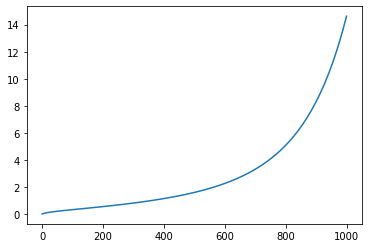

In [269]:
import matplotlib.pyplot as plt

plt.plot(scheduler.timesteps, scheduler.sigmas[:-1])

In [270]:
latents = latents * scheduler.init_noise_sigma

In [271]:
from tqdm.auto import tqdm

for i, t in enumerate(tqdm(scheduler.timesteps)):
    input = torch.cat([latents]*2)
    input = scheduler.scale_model_input(input, t)

    with torch.no_grad():
        pred = unet(
            input, 
            t,
            encoder_hidden_states=text_embeddings,
        ).sample

    pred_uncond, pred_text = pred.chunk(2)
    pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

    latents = scheduler.step(pred, t, latents).prev_sample

  0%|          | 0/70 [00:00<?, ?it/s]

In [272]:
with torch.no_grad():
    image = vae.decode(1 / 0.18215 * latents).sample

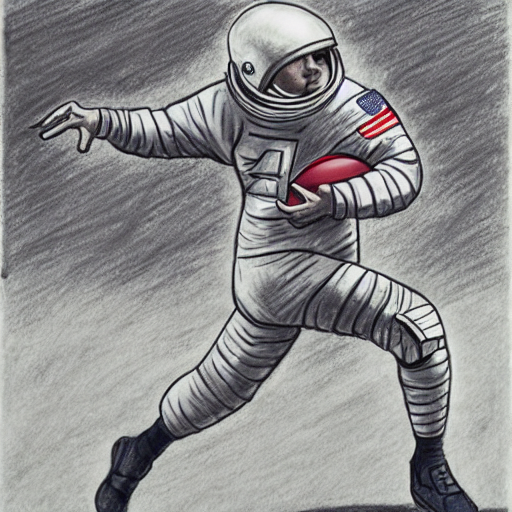

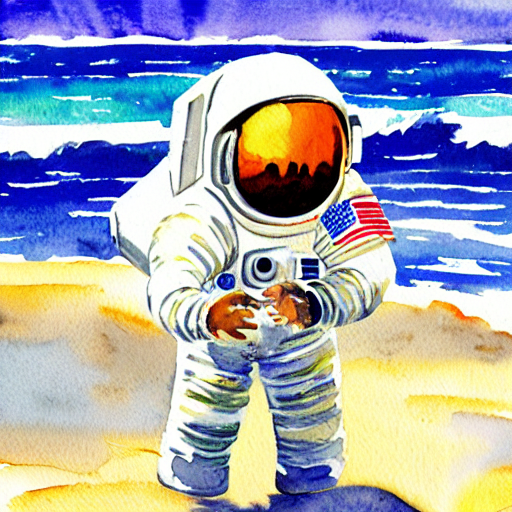

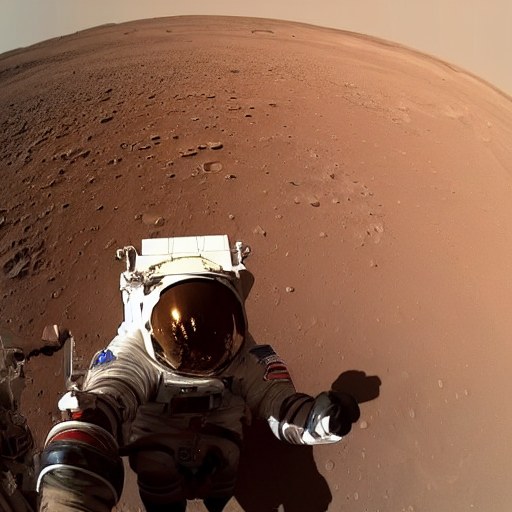

In [273]:
from PIL import Image
from IPython.display import display

image = (image / 2 + 0.5).clamp(0, 1)
for img in image:
    img = img.detach().cpu().permute(1, 2, 0).numpy()
    img = (img * 255).round().astype("uint8")
    display(Image.fromarray(img))